In [4]:
# Importa le librerie necessarie
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [5]:
# Crea una sessione Spark
spark = SparkSession.builder.appName("StudentDepressionRandomForest").getOrCreate()

df = spark.read.csv("file:///home/emanuele_fossi1201/EDA_Student_Depression_Dataset.csv", header=True, inferSchema=True)
df.show(5)


25/05/16 16:21:12 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:12 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:12 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:12 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:12 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:13 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:13 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated

+------+----+-----------------+----+------------------+--------------+------------------------------------+----------------+----------------+--------------------------------+----------+-------------+----------------------+-----------------------+------------------------+---------------+------------------+------------------+
|Gender| Age|Academic_Pressure|CGPA|Study_Satisfaction|Sleep_Duration|Have_you_ever_had_suicidal_thoughts?|Work/Study_Hours|Financial_Stress|Family_History_of_Mental_Illness|Depression|Is_Metropolis|Dietary_Habits_Healthy|Dietary_Habits_Moderate|Dietary_Habits_Unhealthy|Degree_bachelor|Degree_high_school|Degree_masters_phd|
+------+----+-----------------+----+------------------+--------------+------------------------------------+----------------+----------------+--------------------------------+----------+-------------+----------------------+-----------------------+------------------------+---------------+------------------+------------------+
|     1|33.0|         

25/05/16 16:21:20 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.


In [6]:
# Preprocessing: Creazione della feature "features" combinando tutte le colonne numeriche
columns = df.columns
columns.remove('Depression')

# Crea il VectorAssembler
assembler = VectorAssembler(inputCols=columns, outputCol="features")


In [7]:

# Splitta i dati in training e test (80% training, 20% test)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

In [8]:
# Definisci il classificatore
rf = RandomForestClassifier(labelCol="Depression", featuresCol="features")

# Crea la griglia di parametri leggera
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [100]) \
    .addGrid(rf.maxDepth, [10]) \
    .addGrid(rf.maxBins, [32]) \
    .build()

# Crea l'evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Depression", metricName="areaUnderROC")

# Crea il CrossValidator
crossval = CrossValidator(estimator=Pipeline(stages=[assembler, rf]),
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

# Esegui il training del modello con la validazione incrociata
start_time_cv = time.time()
cv_model = crossval.fit(train_data)
end_time_cv = time.time()

print(f"Tempo cross-validation: {end_time_cv - start_time_cv:.2f} secondi")

# Fai previsioni e valuta
predictions_cv = cv_model.transform(test_data)
auc_cv = evaluator.evaluate(predictions_cv)
print(f"AUC (Cross-Validated): {auc_cv}")

25/05/16 16:21:31 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:32 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:32 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:33 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1856.5 KiB
25/05/16 16:21:45 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/05/16 16:21:48 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
25/05/16 16:21:49 WARN DAGScheduler: Broadcasting large task binary with size 1653.5 KiB
25/05/16 16:21:51 WARN DAGScheduler: B

Tempo cross-validation: 86.93 secondi


25/05/16 16:22:58 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:22:59 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
25/05/16 16:22:59 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
[Stage 144:>                                                        (0 + 1) / 1]

AUC (Cross-Validated): 0.9188444495097156


In [9]:
# Addestramento del modello senza cross-validation
rf = RandomForestClassifier(labelCol="Depression", featuresCol="features", numTrees=200, maxDepth=10)
pipeline = Pipeline(stages=[assembler, rf])

# Inizio della misurazione del tempo di addestramento
start_time = time.time()
pipeline_model = pipeline.fit(train_data)
end_time = time.time()

# Calcola e stampa il tempo di addestramento
training_time = end_time - start_time
print(f"Tempo di addestramento: {training_time:.2f} secondi")

25/05/16 16:23:00 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:00 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:00 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:00 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:00 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:00 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:01 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated

Tempo di addestramento: 47.09 secondi


In [10]:
# Fai le predizioni sul set di test
predictions = pipeline_model.transform(test_data)

# Visualizza le prime 50 predizioni
predictions.select("prediction", "Depression").show(50)

# Valuta il modello utilizzando l'AUC
evaluator = BinaryClassificationEvaluator(labelCol="Depression")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")


25/05/16 16:23:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/05/16 16:23:47 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:48 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
25/05/16 16:23:48 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
                                                                                

+----------+----------+
|prediction|Depression|
+----------+----------+
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       0.0|         0|
|       1.0|         0|
|       0.0|         1|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       0.0|         0|
|       1.0|         1|
|       0.0|         0|
|       1.0|         1|
|       1.0|         1|
|       1.0|         1|
|       1.0|         1|
|       1.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         0|
|       0.0|         1|
|       1.0|         1|
|       0.0|         0|
|       0.0|         0|
|       1.0|         1|
|       1.0|         0|
|       1.0|         1|
|       0.0|         1|
|       1.0|         1|
|       1.0|    

25/05/16 16:23:48 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:49 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
25/05/16 16:23:50 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.


AUC: 0.9190517266523535


25/05/16 16:23:51 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:51 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:51 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
25/05/16 16:23:53 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
25/05/16 16:23:53 WARN FileSystem: "instance-20250422-084356:9000" is a deprecated filesystem name. Use "hdfs://instance-20250422-084356:9000/" instead.
                                                                                


Accuracy score on the test set: 0.8531165311653116

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      2264
           1       0.86      0.89      0.88      3271

    accuracy                           0.85      5535
   macro avg       0.85      0.84      0.85      5535
weighted avg       0.85      0.85      0.85      5535



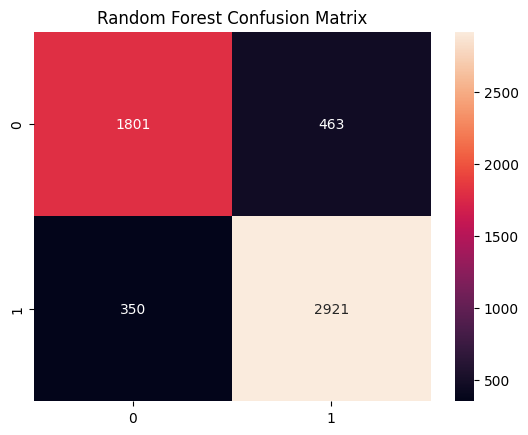

In [11]:
# Calcola metriche aggiuntive con sklearn
t_test = predictions.select('Depression').toPandas()
t_hat = predictions.select('prediction').toPandas()

print(f"\nAccuracy score on the test set: {accuracy_score(t_test, t_hat)}")
print(f"\nClassification Report:\n{classification_report(t_test, t_hat)}")

# Confusion Matrix
cm = confusion_matrix(t_test, t_hat)
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt='d', ax=ax)
ax.set_title('Random Forest Confusion Matrix')
plt.show()
